In [ ]:
%pip install transformers
%pip install torch
%pip install pandas
%pip install scikit-learn
%pip install matplotlib

In [1]:
import torch
from transformers import BertModel, BertConfig
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix


d:\GitHub\Blockchain-Smart-Contract-Security\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

df = pd.read_csv('D:\GitHub\Blockchain-Smart-Contract-Security\solidity_vulnerabilities.csv')
df.head()


,tokens,label
0,"['function', 'sweep', '(', 'address', '_token'...",0
1,"['function', 'sweep', '(', 'address', '_token'...",0
2,"['function', 'sweep', '(', 'address', '_token'...",0
3,"['function', 'events', '(', ')', '{', 'if', '(...",0
4,"['function', 'events', '(', ')', '{', 'if', '(...",0


In [3]:

class SolidityDataset(Dataset):
    def __init__(self, data, max_len):
        self.data = data
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        input_ids = self.data.iloc[index]['tokens']  
        label = self.data.iloc[index]['label']
        
        # Padding and truncation
        padding_length = self.max_len - len(input_ids)
        if padding_length > 0:
            input_ids = input_ids + [0] * padding_length
            attention_mask = [1] * len(input_ids) + [0] * padding_length
        else:
            input_ids = input_ids[:self.max_len]
            attention_mask = [1] * self.max_len
        
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }


MAX_LEN = 64
BATCH_SIZE = 8

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = SolidityDataset(train_data, MAX_LEN)
test_dataset = SolidityDataset(test_data, MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Epoch 1/3


Evaluating: 100%|██████████| 126/126 [00:04<00:00, 30.63batch/s, Loss=0.0708, Accuracy=0.845]


Train Loss: 0.4644
Validation Loss: 0.2929, Validation Accuracy: 0.8449
Epoch 2/3


Evaluating: 100%|██████████| 126/126 [00:04<00:00, 31.12batch/s, Loss=0.0829, Accuracy=0.843]


Train Loss: 0.2706
Validation Loss: 0.2809, Validation Accuracy: 0.8429
Epoch 3/3


Evaluating: 100%|██████████| 126/126 [00:04<00:00, 28.81batch/s, Loss=0.0799, Accuracy=0.852]


Train Loss: 0.2610
Validation Loss: 0.2578, Validation Accuracy: 0.8519


Evaluating: 100%|██████████| 126/126 [00:04<00:00, 29.61batch/s, Loss=0.0799, Accuracy=0.852]


Test Loss: 0.2578, Test Accuracy: 0.8519


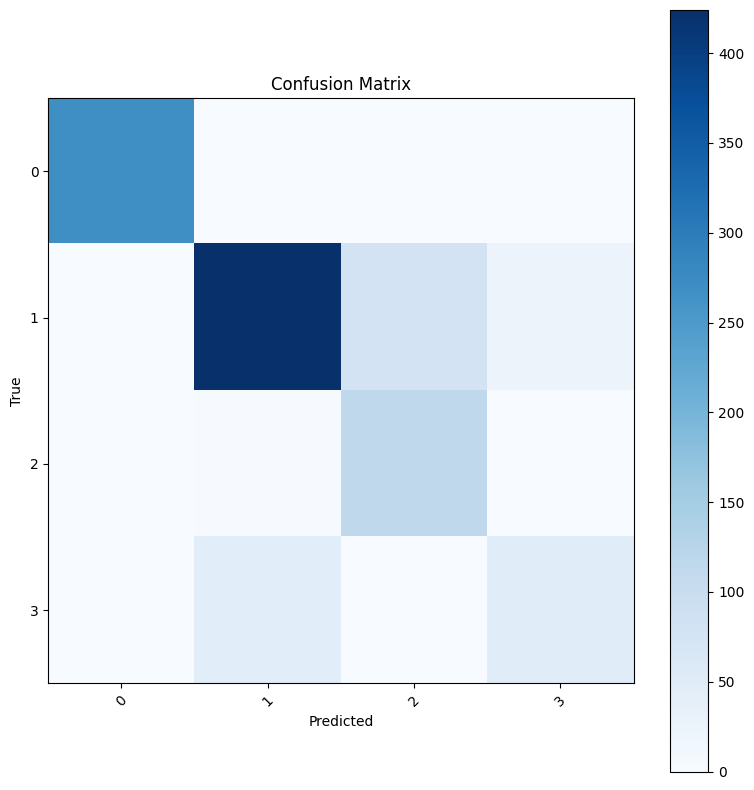

In [6]:
class CustomBERTModel(torch.nn.Module):
    def __init__(self, config, num_classes):
        super(CustomBERTModel, self).__init__()
        self.bert = BertModel(config)
        self.classifier = torch.nn.Linear(config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.classifier(pooled_output)


config = BertConfig(
    hidden_size=768,
    num_attention_heads=4,
    num_hidden_layers=12,
    intermediate_size=3072,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)

NUM_CLASSES = 4

model = CustomBERTModel(config, NUM_CLASSES)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

EPOCHS = 3
LEARNING_RATE = 2e-5
EPSILON = 1e-8

#đánh giá lỗi, lan truyền ngược
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=EPSILON)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# trainning
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Training", unit="batch")
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.set_postfix({"Loss": loss.item()})
    return total_loss / len(dataloader)

#evalute
def eval_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_labels = []
    all_preds = []
    progress_bar = tqdm(dataloader, desc="Evaluating", unit="batch")
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            progress_bar.set_postfix({"Loss": loss.item(), "Accuracy": correct_predictions.item() / len(dataloader.dataset)})
    return total_loss / len(dataloader), correct_predictions.double() / len(dataloader.dataset), all_labels, all_preds


for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss = train_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = eval_model(model, test_dataloader, criterion, device)
    scheduler.step()
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


test_loss, test_acc, test_labels, test_preds = eval_model(model, test_dataloader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(set(test_labels)))
plt.xticks(tick_marks, set(test_labels), rotation=45)
plt.yticks(tick_marks, set(test_labels))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

4 mutil-head attention

Epoch 1/3
Training: 100%|██████████| 503/503 [00:52<00:00,  9.57batch/s, Loss=0.376] 
Evaluating: 100%|██████████| 126/126 [00:04<00:00, 30.63batch/s, Loss=0.0708, Accuracy=0.845]
Train Loss: 0.4644
Validation Loss: 0.2929, Validation Accuracy: 0.8449
Epoch 2/3
Training: 100%|██████████| 503/503 [00:53<00:00,  9.47batch/s, Loss=0.302]  
Evaluating: 100%|██████████| 126/126 [00:04<00:00, 31.12batch/s, Loss=0.0829, Accuracy=0.843]
Train Loss: 0.2706
Validation Loss: 0.2809, Validation Accuracy: 0.8429
Epoch 3/3
Training: 100%|██████████| 503/503 [00:54<00:00,  9.29batch/s, Loss=0.382]  
Evaluating: 100%|██████████| 126/126 [00:04<00:00, 28.81batch/s, Loss=0.0799, Accuracy=0.852]
Train Loss: 0.2610
Validation Loss: 0.2578, Validation Accuracy: 0.8519
Evaluating: 100%|██████████| 126/126 [00:04<00:00, 29.61batch/s, Loss=0.0799, Accuracy=0.852]
Test Loss: 0.2578, Test Accuracy: 0.8519
